In [1]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tqdm

import os, sys, torch, dgl
import numpy as np
import pandas as pd
from torch_geometric.data import Data

from turtle import forward
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import dgl
import dgl.nn.pytorch as dglnn
# from dgl.nn import Set2Set

from torch_geometric.nn import SAGEConv, SAGPooling, Set2Set, GraphNorm, global_sort_pool, GlobalAttention
from torch_geometric.utils import add_self_loops, subgraph
# from torch_geometric.loader import DataLoader

from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics

import dgl
from dgl.nn.pytorch.factory import KNNGraph
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GATConv

# read dataset

In [2]:
# omics_files= ["./data/GBM/GBM.expression.csv.gz", "./data/GBM/GBM.met.csv.gz", "./data/GBM/GBM.cnv.csv.gz"]
# label_file = "./data/GBM/labels.csv"

In [145]:
omics_files=["/home/PJLAB/liangbilin/share/DeepMOI_rawdata/GBM/raw/rna.csv.gz", 
             "/home/PJLAB/liangbilin/share/DeepMOI_rawdata/GBM/raw/cnv.csv.gz",
             "/home/PJLAB/liangbilin/share/DeepMOI_rawdata/GBM/raw/met.csv.gz",
            ]
label_file = "./dataset/GBM/labels.csv"
clin_files = "/home/PJLAB/liangbilin/share/DeepMOI_rawdata/GBM/raw/clin.csv.gz"

In [146]:
# 读取组学数据集
df_omics = []
for f in omics_files:
    df_omics.append( pd.read_csv(f, index_col=0, compression='gzip') )

In [147]:
df_omics[0]

,AACS,FSTL1,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,SAMD4A,SMARCD3,A4GNT,...,KIAA0802,DHRS2,RAB8A,SGEF,PIK3IP1,RPS27,SNRPD2,SLC39A6,CTSC,AQP7
TCGA.02.0001,6.5006,8.7297,5.5114,4.8830,10.9848,7.5352,8.6740,5.0326,4.7110,5.1085,...,7.0312,7.1536,9.0489,4.3661,6.0540,12.9119,11.8723,6.8677,10.3541,4.7099
TCGA.02.0003,6.5392,9.7944,6.2140,4.8363,10.8112,6.9979,9.3486,5.0270,5.3277,4.3486,...,6.3055,4.0069,8.8645,4.3853,6.6742,13.4194,11.1097,8.1478,11.3674,4.1964
TCGA.02.0004,7.3778,12.0596,7.0517,6.1124,10.4364,9.1321,11.2485,5.5591,8.2682,4.0524,...,5.9481,4.0251,8.8457,4.8149,6.4645,13.2296,11.3210,8.5192,10.3795,3.7339
TCGA.02.0007,7.1869,4.9451,5.2304,5.8186,10.4773,8.3561,4.4295,5.1759,4.4405,4.8242,...,6.5024,4.2905,8.4836,4.7985,5.0602,13.5751,11.6656,9.1899,11.4782,4.3231
TCGA.02.0009,7.6750,10.8401,6.6207,5.3332,10.6373,6.9429,9.4522,5.1649,4.9522,4.2046,...,5.1425,5.4105,9.2392,4.3432,6.4780,13.2870,11.4804,8.5564,10.4047,4.6391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.76.6193,6.9078,11.0918,7.8877,4.6878,10.4751,9.1383,8.8234,5.8607,7.6563,4.0581,...,7.5395,3.9214,9.5287,5.3819,6.7406,13.3434,10.1613,9.2649,10.7787,3.6473
TCGA.76.6282,7.0076,10.7895,7.5698,5.3670,10.5730,9.4382,9.3430,5.5792,8.8727,4.2519,...,7.0506,3.8547,9.6149,6.4983,6.6245,13.1790,10.8780,8.8396,9.9779,3.7119
TCGA.76.6285,7.6763,9.6826,7.0198,4.6857,10.4392,10.2042,8.1278,5.4004,8.4735,4.1489,...,6.8089,3.8723,9.4569,7.9970,6.7170,13.5058,10.5722,8.8872,9.4662,3.6692
TCGA.81.5910,7.1052,9.8474,7.5335,6.1549,10.6853,10.2206,7.0747,6.1500,8.5697,4.3660,...,7.6320,3.9390,9.5651,5.7329,5.3812,13.3282,11.1809,9.8162,8.0059,3.8327


In [148]:
df_omic = df_omics[0]
for i in range(df_omic.shape[1]):
    data = df_omic.iloc[:, i].values
    data = np.expand_dims(data, 1)
    
    scores = []
    for k in range(5):
        score = fds(data)
        scores.append(score)
    if np.mean(scores) > 0.4 and np.mean(scores) < 0.6:
        print(i, np.mean(scores))



0 0.5606060606060606
1 0.5242424242424242
2 0.5272727272727272
3 0.4878787878787879
4 0.5106060606060606
5 0.5287878787878788
6 0.49393939393939396
7 0.4409090909090909
8 0.503030303030303
9 0.5303030303030303
10 0.5787878787878789
11 0.5378787878787878
12 0.49393939393939396
13 0.5363636363636364
14 0.47424242424242424
15 0.5151515151515152
16 0.4803030303030303
17 0.5363636363636364
18 0.4833333333333334
19 0.5151515151515152
20 0.5757575757575758
21 0.546969696969697
22 0.4924242424242425
23 0.5272727272727272
24 0.4621212121212121
25 0.503030303030303
26 0.49393939393939396
27 0.5136363636363637
28 0.5469696969696969
29 0.48484848484848486
30 0.5106060606060605
31 0.5257575757575758
32 0.49696969696969695
33 0.4909090909090909
34 0.5045454545454545
35 0.5621212121212121
36 0.5212121212121212
37 0.5515151515151515
38 0.5166666666666667
39 0.5242424242424242
40 0.4636363636363637
41 0.5333333333333333
42 0.5272727272727273
43 0.5060606060606061
44 0.48484848484848486
45 0.54545454545

366 0.5272727272727271
367 0.48484848484848486
368 0.5106060606060606
369 0.5272727272727272
370 0.5196969696969698
371 0.45757575757575764
372 0.49393939393939396
373 0.4636363636363637
374 0.48939393939393944
375 0.5318181818181819
376 0.5318181818181819
377 0.5242424242424242
378 0.5363636363636364
379 0.5272727272727272
380 0.509090909090909
381 0.4878787878787879
382 0.5060606060606061
383 0.5166666666666666
384 0.5545454545454545
385 0.46818181818181814
386 0.5287878787878789
387 0.4409090909090909
388 0.5060606060606061
389 0.5333333333333334
390 0.5515151515151515
391 0.5106060606060606
392 0.5196969696969698
393 0.5015151515151516
394 0.5424242424242424
395 0.5121212121212121
396 0.4909090909090909
397 0.5106060606060606
398 0.4924242424242424
399 0.5409090909090909
400 0.4954545454545455
401 0.4909090909090909
402 0.5166666666666667
403 0.48484848484848486
404 0.4818181818181818
405 0.5166666666666666
406 0.5590909090909092
407 0.5166666666666666
408 0.5136363636363637
409 0.

728 0.47727272727272724
729 0.45606060606060606
730 0.543939393939394
731 0.5666666666666667
732 0.5121212121212121
733 0.5424242424242424
734 0.5424242424242424
735 0.5545454545454546
736 0.5015151515151516
737 0.5545454545454546
738 0.453030303030303
739 0.4878787878787879
740 0.47272727272727266
741 0.5060606060606061
742 0.4924242424242424
743 0.543939393939394
744 0.4606060606060606
745 0.5106060606060605
746 0.5030303030303029
747 0.49848484848484853
748 0.453030303030303
749 0.5303030303030303
750 0.503030303030303
751 0.5075757575757576
752 0.5363636363636364
753 0.5303030303030304
754 0.543939393939394
755 0.5030303030303029
756 0.5106060606060606
757 0.44848484848484854
758 0.4454545454545455
759 0.509090909090909
760 0.4803030303030303
761 0.44848484848484843
762 0.503030303030303
763 0.4712121212121213
764 0.4984848484848484
765 0.4833333333333333
766 0.4787878787878787
767 0.5863636363636363
768 0.515151515151515
769 0.543939393939394
770 0.5227272727272727
771 0.512121212

KeyboardInterrupt: 

In [149]:
# 读取临床特征
df_clin = pd.read_csv(clin_files, compression='gzip', index_col=0)

In [150]:
df_clin

,years_to_birth,Tumor_purity,histological_type_glioblastomamultiforme(gbm),histological_type_treatedprimarygbm,histological_type_untreatedprimary(denovo)gbm,gender_female,gender_male,radiation_therapy_no,radiation_therapy_yes
attrib_name,,,,,,,,,
TCGA.06.6391,0.44,0.8360,0,0,1,1,0,1,0
TCGA.19.A6J4,0.68,0.6736,1,0,0,0,1,0,0
TCGA.06.1806,0.47,0.7913,1,0,0,0,1,0,1
TCGA.06.5408,0.54,0.8635,0,0,1,1,0,0,1
TCGA.06.5410,0.72,0.3396,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...
TCGA.76.6283,0.71,0.9779,1,0,0,1,0,0,0
TCGA.76.6660,0.73,0.7707,1,0,0,0,1,0,0
TCGA.81.5910,0.64,0.7913,0,0,1,0,1,1,0


In [151]:
# 读取标签
df_label = pd.read_csv(label_file, index_col=0)

df_label

,label
patient_id,
TCGA.06.6391,1
TCGA.19.A6J4,1
TCGA.06.1806,1
TCGA.06.5408,1
TCGA.06.5410,1
...,...
TCGA.76.6280,1
TCGA.76.6283,1
TCGA.76.6660,1


In [152]:
df_label = df_label.rename(
        columns={df_label.columns.values[0]: 'patient'})
df_label

,patient
patient_id,
TCGA.06.6391,1
TCGA.19.A6J4,1
TCGA.06.1806,1
TCGA.06.5408,1
TCGA.06.5410,1
...,...
TCGA.76.6280,1
TCGA.76.6283,1
TCGA.76.6660,1


In [153]:
# 计算患者交集
patients = [df_tmp.index.to_list() for df_tmp in df_omics]
patients.append(df_clin.index.to_list())
patients.append(df_label.index.to_list())

patients_shared = patients[0]
print(len(patients_shared))
for i in range(1, len(patients)):
    patients_shared = list(set(patients_shared).intersection(patients[i]))
    print(len(patients[i]), len(patients_shared))

len(patients_shared)

528
577 508
285 270
567 254
494 220


220

In [154]:
# 提取交集
for i in range(len(df_omics)):
    df_omics[i] = df_omics[i].loc[patients_shared, :]
df_clin = df_clin.loc[patients_shared, :]
df_label = df_label.loc[patients_shared, :]

In [155]:
def check_v1(data, labels, seed=0):
    # check label0 vs. label1: need (p<0.05)
    label_1 = [True if i==1 else False for i in labels]
    label_0 = [True if i==0 else False for i in labels]
    pvalue_01 = stats.kstest(data[label_1], data[label_0]).pvalue
    
    # check train vs. test for total data: need (p>0.05)
    _, X_test, _, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
    label_1 = [True if i==1 else False for i in y_test]
    label_0 = [True if i==0 else False for i in y_test]
    pvalue_02 = stats.kstest(X_test[label_1], X_test[label_0]).pvalue
    pvalue_03 = stats.kstest(X_test, data).pvalue
       
    return pvalue_01, pvalue_02, pvalue_03

In [159]:
df_label.columns = ['label']

In [160]:
dat = df_omics[0].values
labels = df_label.label.values

np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)


df_boot = pd.DataFrame()

for i in tqdm.tqdm(range(dat.shape[1])):
    data = dat[:, i]
    m = 0
    for n, seed in enumerate(seeds):
        pvalue_01, pvalue_02, pvalue_03 = check_v1(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_02 < 0.05 and pvalue_03>0.05:
            m += 1
    m = m / n
    df_boot.loc[i, 'rna'] = m

100%|████████████████████████████████████████████████████████████████████████████████████████████| 12042/12042 [05:34<00:00, 35.98it/s]


In [161]:
dat = df_omics[1].values
labels = df_label.label.values

np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)


# df_boot = pd.DataFrame(columns=list(range(df_omics[0].shape[1])))

for i in tqdm.tqdm(range(dat.shape[1])):
    data = dat[:, i]
    m = 0
    for n, seed in enumerate(seeds):
        pvalue_01, pvalue_02, pvalue_03 = check_v1(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_02 < 0.05 and pvalue_03>0.05:
            m += 1
    m = m / n
    df_boot.loc[i, 'cnv'] = m

100%|████████████████████████████████████████████████████████████████████████████████████████████| 24776/24776 [11:36<00:00, 35.57it/s]


In [162]:
dat = df_omics[2].values
labels = df_label.label.values

np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)


# df_boot = pd.DataFrame(columns=list(range(df_omics[0].shape[1])))

for i in tqdm.tqdm(range(dat.shape[1])):
    data = dat[:, i]
    m = 0
    for n, seed in enumerate(seeds):
        pvalue_01, pvalue_02, pvalue_03 = check_v1(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_02 < 0.05 and pvalue_03>0.05:
            m += 1
    m = m / n
    df_boot.loc[i, 'met'] = m

100%|████████████████████████████████████████████████████████████████████████████████████████████| 13774/13774 [06:18<00:00, 36.38it/s]


In [163]:
p = 0.7
rna = df_boot[df_boot.rna > p].index.to_list()
cnv = df_boot[df_boot.cnv > p].index.to_list()
met = df_boot[df_boot.met > p].index.to_list()

In [164]:
len(rna), len(cnv), len(met)

(26, 0, 8)

In [10]:
dat = df_omics[1].values
labels = df_label.label.values

np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_02, pvalue_03 = check_v1(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_02 < 0.05 and pvalue_03>0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))

cnv = candidates_list

100%|███████████████████████████████████████████████████████████████████████████████████████████| 24776/24776 [01:08<00:00, 363.45it/s]


Seed: 102 | Candidates' Number: 444


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 444/444 [00:01<00:00, 368.77it/s]


Seed: 435 | Candidates' Number: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 348.41it/s]


Seed: 860 | Candidates' Number: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 314.78it/s]


Seed: 270 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 106 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 71 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 700 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 121 | Candidates' Number: 0


In [11]:
dat = df_omics[2].values
labels = df_label.label.values

np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_02, pvalue_03 = check_v1(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_02 < 0.05 and pvalue_03>0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))

met = candidates_list

100%|███████████████████████████████████████████████████████████████████████████████████████████| 13774/13774 [00:38<00:00, 358.35it/s]


Seed: 102 | Candidates' Number: 328


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:00<00:00, 372.23it/s]


Seed: 435 | Candidates' Number: 96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 362.74it/s]


Seed: 860 | Candidates' Number: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 359.38it/s]


Seed: 270 | Candidates' Number: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 347.64it/s]


Seed: 106 | Candidates' Number: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 240.62it/s]


Seed: 71 | Candidates' Number: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 349.79it/s]


Seed: 700 | Candidates' Number: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 310.86it/s]


Seed: 20 | Candidates' Number: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 338.95it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 121 | Candidates' Number: 0


In [3]:
df = pd.read_csv(omics_files[0], compression='gzip')
df = df.set_index('gene').T.sort_index()
dat = df.values

In [13]:
df = pd.read_csv(omics_files[0], compression='gzip')
df

,gene,TCGA.12.3652,TCGA.19.0960,TCGA.12.1099,TCGA.06.0130,TCGA.02.0028,TCGA.28.1750,TCGA.32.2616,TCGA.06.2564,TCGA.16.1056,...,TCGA.12.1091,TCGA.06.2570,TCGA.32.1986,TCGA.19.2629,TCGA.14.1795,TCGA.27.2524,TCGA.02.0074,TCGA.02.0057,TCGA.06.0876,TCGA.28.1747
0,65985,7.1738,7.3166,6.8582,6.5383,6.2721,7.0676,8.0759,7.2686,5.9117,...,6.7674,7.1291,7.0174,7.1295,6.8996,7.6271,7.1464,7.1611,7.0298,7.1537
1,11167,9.3542,8.4556,8.0170,11.1657,9.0426,10.0037,10.1780,10.5338,10.3707,...,8.9370,9.4463,10.8694,9.5244,9.2726,9.8123,9.7812,10.2272,9.9774,10.3286
2,63916,6.6920,7.4992,6.5713,6.7394,5.9621,7.0352,7.3856,7.8099,6.2439,...,6.7410,7.7636,7.0640,7.9254,6.8660,6.8903,7.6113,6.4961,7.0368,8.1422
3,6205,11.6890,10.6997,10.7380,10.5810,10.5937,10.4388,11.1990,10.7997,10.7321,...,11.0581,10.8540,10.5805,10.9335,10.2738,11.0040,10.6266,10.5731,11.6288,10.5701
4,9240,9.7894,10.1381,9.0477,8.2948,7.2465,9.1440,9.8858,10.2969,9.5922,...,8.8233,10.3760,10.1381,9.8334,10.1661,9.6827,9.3484,8.9108,9.5088,10.3280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8569,6232,13.4681,13.3225,13.2468,12.9222,13.2518,12.5522,13.3687,13.2221,13.2427,...,13.4064,13.4744,13.3066,13.2431,12.5956,13.2832,12.7542,13.3787,13.4558,13.0392
8570,6633,12.5007,9.5415,10.7869,11.1401,10.6949,10.8122,10.6902,10.7629,10.0993,...,10.9102,10.9260,10.9236,10.6743,11.0020,12.3243,11.5169,11.1037,11.3967,11.0119
8571,25800,9.0119,9.7287,9.2825,9.4069,7.3751,8.7975,8.8737,9.2659,9.0218,...,9.5355,9.7649,9.3658,10.3708,9.1447,8.9571,10.5572,8.4873,8.7153,9.1383
8572,1075,7.6762,9.1204,9.0587,10.7588,11.3272,9.9070,8.9027,9.2750,8.7297,...,8.5790,9.2406,9.4352,9.4494,9.5590,11.1655,9.4927,10.9043,9.0236,9.3242


In [4]:
df = pd.read_csv(omics_files[0], compression='gzip')
df = df.set_index('gene').T.sort_index()
df

gene,65985,11167,63916,6205,9240,4313,23034,6604,51146,23051,...,66035,4318,2822,4218,113791,6232,6633,25800,1075,364
TCGA.02.0001,6.5006,8.7297,5.5114,10.9848,7.5352,8.6740,5.0326,4.7110,5.1085,5.0578,...,3.8104,10.1073,4.2646,9.0489,6.0540,12.9119,11.8723,6.8677,10.3541,4.7099
TCGA.02.0003,6.5392,9.7944,6.2140,10.8112,6.9979,9.3486,5.0270,5.3277,4.3486,5.0185,...,3.8114,9.2451,4.3928,8.8645,6.6742,13.4194,11.1097,8.1478,11.3674,4.1964
TCGA.02.0007,7.1869,4.9451,5.2304,10.4773,8.3561,4.4295,5.1759,4.4405,4.8242,5.3092,...,4.0554,4.9841,4.3993,8.4836,5.0602,13.5751,11.6656,9.1899,11.4782,4.3231
TCGA.02.0009,7.6750,10.8401,6.6207,10.6373,6.9429,9.4522,5.1649,4.9522,4.2046,5.1934,...,3.7961,9.4838,4.1058,9.2392,6.4780,13.2870,11.4804,8.5564,10.4047,4.6391
TCGA.02.0010,7.9960,8.9316,7.5524,11.0015,8.0444,4.5017,4.9701,8.6390,4.7297,5.6876,...,4.3457,6.3779,4.4098,9.3678,5.7048,13.4803,10.9516,9.2099,8.4179,4.1673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2573,8.3524,9.2781,8.2224,10.9342,10.4176,7.7750,5.1610,9.2291,4.2301,6.7163,...,4.2878,7.4442,4.4620,8.7003,7.2960,13.1763,11.1698,10.1071,9.2850,3.6602
TCGA.41.2575,7.4707,9.0223,7.2680,11.1522,9.0870,8.1914,5.3809,9.4080,4.3760,6.8908,...,4.2864,5.6763,4.6100,8.5116,6.0337,13.4874,11.4938,9.9421,8.5357,3.8522
TCGA.41.3392,7.7575,10.1369,7.7922,11.2145,10.4248,7.9187,5.6151,10.1912,4.1216,7.0976,...,4.2259,7.6174,4.2795,8.7327,7.0284,13.2740,11.7869,9.0605,8.7931,3.6826
TCGA.41.3393,7.1475,9.7595,7.7017,10.9388,9.6555,8.5737,6.0901,8.5130,4.1553,6.8399,...,4.2960,7.9491,4.3866,9.2732,5.9184,13.0283,11.2973,9.6774,10.2152,3.8290


In [20]:
labels = pd.read_csv(label_file)
labels = labels.sort_values('patient_id')
labels = labels[labels.patient_id.isin(df.index.values)]
patients = labels.patient_id.values
labels = labels.label.values
len(patients)

448

# KS Test

In [10]:
def check(data, labels, seed=0):
    # check label0 vs. label1: need (p<0.05)
    label_1 = [True if i==1 else False for i in labels]
    label_0 = [True if i==0 else False for i in labels]
    pvalue_01 = stats.kstest(data[label_1], data[label_0]).pvalue
    
    # check train vs. test for total data: need (p>0.05)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
    pvalue_tt = stats.kstest(X_train, X_test).pvalue
    
    # check label0 vs. label1 in training dataset (p<0.05)
    label_1 = [True if i==1 else False for i in y_train]
    label_0 = [True if i==0 else False for i in y_train]
    pvalue_01_train = stats.kstest(X_train[label_1], X_train[label_0]).pvalue
    
    # check label0 vs. label1 in testing dataset (p<0.05)
    label_1 = [True if i==1 else False for i in y_test]
    label_0 = [True if i==0 else False for i in y_test]
    pvalue_01_test = stats.kstest(X_test[label_1], X_test[label_0]).pvalue
    
    # label1: train vs. test: p>0.05
    label_1_test = [True if i==1 else False for i in y_test]
    label_1_train = [True if i==1 else False for i in y_train]
    pvalue_1_tt = stats.kstest(X_test[label_1_test], X_train[label_1_train]).pvalue
    
    # label0: train vs. test: p>0.05
    label_0_test = [True if i==0 else False for i in y_test]
    label_0_train = [True if i==0 else False for i in y_train]
    pvalue_0_tt = stats.kstest(X_test[label_0_test], X_train[label_0_train]).pvalue
    
    
    return pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt


In [76]:
def check_v1(data, labels, seed=0):
    # check label0 vs. label1: need (p<0.05)
    label_1 = [True if i==1 else False for i in labels]
    label_0 = [True if i==0 else False for i in labels]
    pvalue_01 = stats.kstest(data[label_1], data[label_0]).pvalue
    
    # check train vs. test for total data: need (p>0.05)
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
    pvalue_tt = stats.kstest(X_train, X_test).pvalue
    
    # check label0 vs. label1 in training dataset (p<0.05)
    label_1 = [True if i==1 else False for i in y_train]
    label_0 = [True if i==0 else False for i in y_train]
    pvalue_01_train = stats.kstest(X_train[label_1], X_train[label_0]).pvalue
    
    # check label0 vs. label1 in testing dataset (p<0.05)
    label_1 = [True if i==1 else False for i in y_test]
    label_0 = [True if i==0 else False for i in y_test]
    pvalue_01_test = stats.kstest(X_test[label_1], X_test[label_0]).pvalue
    
    # label1: train vs. test: p>0.05
    label_1_test = [True if i==1 else False for i in y_test]
    label_1_train = [True if i==1 else False for i in y_train]
    pvalue_1_tt = stats.kstest(X_test[label_1_test], X_train[label_1_train]).pvalue
    
    # label0: train vs. test: p>0.05
    label_0_test = [True if i==0 else False for i in y_test]
    label_0_train = [True if i==0 else False for i in y_train]
    pvalue_0_tt = stats.kstest(X_test[label_0_test], X_train[label_0_train]).pvalue
    
    
    return pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt

In [77]:
def distribution(data, labels, seed=0):
    # check label0 vs. label1: need (p<0.05)
    label_1 = [True if i==1 else False for i in labels]
    label_0 = [True if i==0 else False for i in labels]
    pvalue_01 = stats.kstest(data[label_1], data[label_0]).pvalue
    
    # check train vs. test for total data: need (p>0.05)
    _, X_test, _, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
    
    pvalue_tt = stats.kstest(data, X_test).pvalue
#     print(data)
#     print(pvalue_01, pvalue_tt)
    return pvalue_01, pvalue_tt

## RNA

In [9]:
df = pd.read_csv(omics_files[0], compression='gzip')
df = df.rename(columns={df.columns.values[0] : 'gene'})
df = df.drop_duplicates('gene', keep='first')
df = df.sort_values('gene').reset_index(drop=True)
df = df.fillna(0)  # fill nan with 0
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values
dat.shape

(220, 8574)

In [10]:
df = pd.read_csv(omics_files[0], compression='gzip')
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values

dat_rna = dat

In [11]:
labels = pd.read_csv(label_file)
labels = labels.sort_values('patient_id')
labels = labels[labels.patient_id.isin(df.index.values)]
labels = labels.label.values
labels

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [12]:
np.random.seed(42)
seeds = np.random.randint(0, 1000, 10)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt = check(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_tt > 0.05 and pvalue_01_test<0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8574/8574 [00:37<00:00, 225.99it/s]


Seed: 102 | Candidates' Number: 250


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 227.23it/s]


Seed: 435 | Candidates' Number: 81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 223.77it/s]


Seed: 860 | Candidates' Number: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 210.98it/s]


Seed: 270 | Candidates' Number: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 208.63it/s]


Seed: 106 | Candidates' Number: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.85it/s]


Seed: 71 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 700 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 121 | Candidates' Number: 0


In [13]:
candidates_rna = candidates_list

## Met

In [14]:
df = pd.read_csv(omics_files[1], compression='gzip')
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values

dat_met = dat

In [15]:
df

gene,487,4223,3232,24145,3613,389,84525,7287,8148,60481,...,355,54829,50865,1429,9836,6144,10266,192286,6314,26073
TCGA.02.0001,0.3261,-0.4585,-0.0915,-0.3798,-0.4814,-0.4850,-0.2066,0.4394,-0.4758,-0.4719,...,-0.4846,0.3746,-0.4849,-0.4557,-0.4731,-0.4491,-0.4457,-0.4832,-0.4327,-0.4546
TCGA.02.0003,0.1966,-0.3961,-0.4494,-0.4289,-0.3722,-0.4794,-0.3266,0.4203,-0.4797,-0.4649,...,-0.4828,0.3752,-0.4854,-0.4613,-0.4576,-0.3708,-0.4599,-0.4677,-0.4462,-0.4537
TCGA.02.0007,0.3267,-0.4745,0.1464,-0.3042,-0.4815,-0.4652,-0.3636,0.4145,-0.4776,-0.4724,...,-0.4833,0.4064,-0.4818,-0.4710,-0.4772,-0.3221,-0.4614,-0.4745,-0.3596,-0.4561
TCGA.02.0009,0.3360,-0.4587,-0.3111,-0.3700,-0.4805,-0.4561,-0.4413,0.4328,-0.4760,-0.4705,...,-0.4790,0.4384,-0.4864,-0.4507,-0.4786,-0.4241,-0.4544,-0.4816,-0.4449,-0.4617
TCGA.02.0010,0.1871,-0.4627,-0.1366,-0.3640,-0.3567,-0.4867,-0.4539,0.4197,-0.4822,-0.4774,...,0.3486,0.4346,-0.4785,-0.4770,-0.4755,-0.4183,-0.4657,-0.4822,-0.4584,-0.4547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572,0.0977,-0.4582,-0.0950,-0.4209,-0.4338,-0.4892,-0.3772,0.4169,-0.4692,-0.4775,...,-0.4888,0.4327,-0.4424,-0.4774,-0.4854,-0.4777,-0.4799,-0.4821,-0.4825,-0.4838
TCGA.41.2575,-0.4353,-0.4732,0.2135,-0.4350,-0.4839,-0.4841,-0.4442,0.3648,-0.4873,-0.4845,...,-0.4894,0.3271,-0.4847,-0.4837,-0.4812,-0.4675,-0.4773,-0.4833,-0.4758,-0.4739
TCGA.41.3392,-0.1843,-0.4676,-0.4177,-0.4255,-0.4835,-0.4870,-0.4216,0.3755,-0.4842,-0.4848,...,-0.4868,0.4094,-0.4829,-0.4807,-0.4761,-0.4427,-0.4711,-0.4761,-0.4771,-0.4572
TCGA.41.3393,0.2044,-0.4700,0.0912,-0.3737,-0.4840,-0.4869,-0.2230,0.4318,-0.4740,-0.4761,...,-0.4869,0.4376,-0.4575,-0.4837,-0.4854,-0.4780,-0.4736,-0.4855,-0.4717,-0.4809


In [16]:
labels = pd.read_csv(label_file)
labels = labels.sort_values('patient_id')
labels = labels[labels.patient_id.isin(df.index.values)]
labels = labels.label.values

labels

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
np.random.seed(42)
seeds = np.random.randint(0, 1000, 20)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt = check(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_tt > 0.05 and pvalue_01_test<0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8574/8574 [00:37<00:00, 230.25it/s]


Seed: 102 | Candidates' Number: 235


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 235/235 [00:01<00:00, 228.97it/s]


Seed: 435 | Candidates' Number: 86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 86/86 [00:00<00:00, 227.40it/s]


Seed: 860 | Candidates' Number: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 216.30it/s]


Seed: 270 | Candidates' Number: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 211.12it/s]


Seed: 106 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 71 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 700 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 121 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 466 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 214 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 330 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 458 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 87 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 372 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 99 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 871 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 663 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 130 | Candidates' Number: 0


In [18]:
candidates_met = candidates_list

## CNV

In [19]:
df = pd.read_csv(omics_files[2], compression='gzip')
df = df.set_index('gene').T.sort_index()
df = df.loc[patients, :]
dat = df.values

dat_cnv = dat
df

gene,55210,54991,1855,2563,2782,9636,79906,55052,26155,55229,...,79174,5600,6300,23542,23209,29781,6305,9997,80305,9889
TCGA.02.0001,0.242,0.242,0.242,0.242,0.242,0.242,0.242,0.242,0.242,0.242,...,-0.008,-0.008,-0.008,-0.008,-0.008,-0.008,-0.008,-0.008,-0.008,-0.008
TCGA.02.0003,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,...,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021,0.021
TCGA.02.0007,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,-0.072,...,-0.988,-0.988,-0.988,-0.988,-0.988,-0.988,-0.988,-0.988,-0.988,-0.988
TCGA.02.0009,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,...,0.039,0.039,0.039,0.039,0.039,0.039,0.039,0.039,0.039,0.039
TCGA.02.0010,-0.094,-0.094,-0.094,-0.094,-0.094,-0.094,-0.094,-0.094,-0.094,-0.094,...,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190,-0.190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572,-0.062,-0.062,-0.062,-0.062,-0.062,-0.062,-0.062,-0.062,-0.062,-0.062,...,-0.102,-0.102,-0.102,-0.102,-0.102,-0.102,-0.102,-0.102,-0.102,-0.102
TCGA.41.2575,-1.083,-1.083,-1.083,-1.083,-1.083,-1.083,-1.083,-1.083,-1.083,-1.083,...,-1.075,-1.075,-1.075,-1.075,-1.075,-1.075,-1.075,-1.075,-1.075,-1.075
TCGA.41.3392,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,...,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007,-0.007
TCGA.41.3393,-0.031,-0.031,-0.031,-0.031,-0.031,-0.031,-0.031,-0.031,-0.031,-0.031,...,-0.034,-0.034,-0.034,-0.034,-0.034,-0.034,-0.034,-0.034,-0.034,-0.034


In [20]:
np.random.seed(42)
seeds = np.random.randint(0, 1000, 20)

candidates_list = []
candidates_list.append(range(dat.shape[1]))

for n, seed in enumerate(seeds):
    candidates_list.append([])
    for i in tqdm.tqdm(candidates_list[n]):
        data = dat[:, i]
        pvalue_01, pvalue_tt, pvalue_01_train, pvalue_01_test, pvalue_1_tt, pvalue_0_tt = check(data=data, labels=labels, seed=seed)
        if pvalue_01 < 0.05 and pvalue_tt > 0.05 and pvalue_01_test<0.05:
            candidates_list[n+1].append(i)
    print("Seed: {} | Candidates' Number: {}".format(seed, len(candidates_list[n+1])))


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 8574/8574 [00:37<00:00, 230.86it/s]


Seed: 102 | Candidates' Number: 340


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:01<00:00, 231.86it/s]


Seed: 435 | Candidates' Number: 168


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 229.22it/s]


Seed: 860 | Candidates' Number: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 215.02it/s]


Seed: 270 | Candidates' Number: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 212.39it/s]


Seed: 106 | Candidates' Number: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 216.01it/s]


Seed: 71 | Candidates' Number: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 211.37it/s]


Seed: 700 | Candidates' Number: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 220.80it/s]


Seed: 20 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 614 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 121 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 466 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 214 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 330 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 458 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 87 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 372 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 99 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 871 | Candidates' Number: 0


0it [00:00, ?it/s]


Seed: 663 | Candidates' Number: 0


0it [00:00, ?it/s]

Seed: 130 | Candidates' Number: 0


In [21]:
candidates_cnv = candidates_list

# 构建机器学习模型

In [43]:
data = np.concatenate([dat_rna[:, candidates_rna[1]], dat_met[:, candidates_met[1]], dat_cnv[:, candidates_cnv[1]] ], 1)

data = np.nan_to_num(data)

data = data.astype('float32')

NameError: name 'dat_rna' is not defined

In [131]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=seeds[-1]) 

In [132]:
from sklearn.ensemble import RandomForestClassifier     #导入需要的模块

rfc = RandomForestClassifier( n_jobs=-1)                      #实例化
rfc = rfc.fit(X_train,y_train)                      #用训练集数据训练模型
result = rfc.score(X_test,y_test) 

result

0.8939393939393939

In [140]:
X_train.ravel()

array([10.1772,  4.9998,  3.8827, ...,  1.    ,  0.    ,  1.    ],
      dtype=float32)

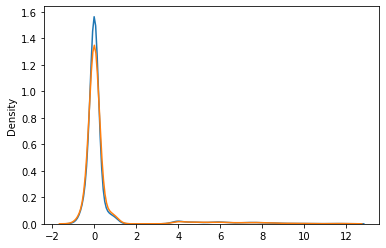

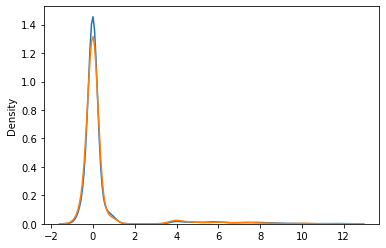

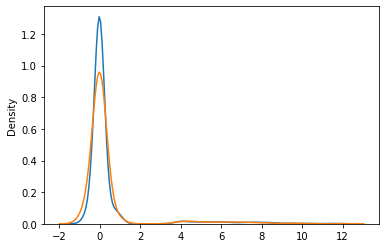

In [143]:
i = 10
sns.kdeplot(X_train.ravel())
sns.kdeplot(X_test.ravel())
plt.show()

idx = [True if i == 1 else False for i in y_train]
sns.kdeplot(X_train[:,:][idx].ravel())
idx = [True if i == 0 else False for i in y_train]
sns.kdeplot(X_train[:,:][idx].ravel())
plt.show()

idx = [True if i == 1 else False for i in y_test]
sns.kdeplot(X_test[:,:][idx].ravel())
idx = [True if i == 0 else False for i in y_test]
sns.kdeplot(X_test[:,:][idx].ravel())
plt.show()

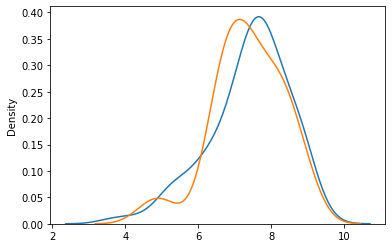

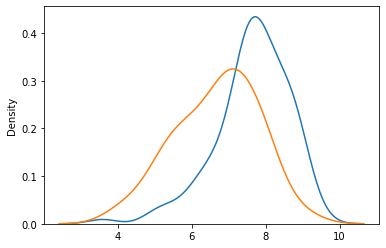

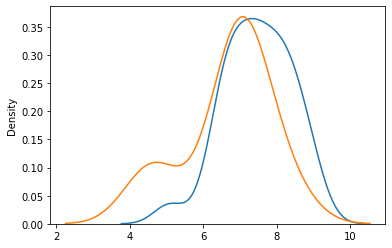

In [149]:
i = 5
sns.kdeplot(X_train[:,i])
sns.kdeplot(X_test[:,i])
plt.show()

idx = [True if i == 1 else False for i in y_train]
sns.kdeplot(X_train[:,i][idx])
idx = [True if i == 0 else False for i in y_train]
sns.kdeplot(X_train[:,i][idx])
plt.show()

idx = [True if i == 1 else False for i in y_test]
sns.kdeplot(X_test[:,i][idx])
idx = [True if i == 0 else False for i in y_test]
sns.kdeplot(X_test[:,i][idx])
plt.show()

# 构建Deep learning 模型

In [190]:
dataset = df_omic.iloc[:120, :100]
dataset = torch.tensor(dataset.values, dtype=torch.float32)

labels = [0]*40 + [1]*40 + [2]*40
labels = np.array(labels)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [197]:
class DeepMOI(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(DeepMOI, self).__init__()
        self.lin1 = nn.Linear(in_feat, 256)
        self.lin2 = nn.Linear(256, 64)
        self.lin3 = nn.Linear(64, out_feat)
        
    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
        x = F.dropout(x, 0.5)
        
        x = self.lin2(x)
        x = torch.relu(x)
        x = F.dropout(x, 0.5)
        
        x = self.lin3(x)
        
#         return F.softmax(x, dim=1)
        return x

In [202]:
model = DeepMOI(100, 3)

y_pred_prob = model(dataset)

# y_pred = np.argmax(y_pred_prob, 1)

# y_pred

tensor([[0.1535, 0.4403, 0.4062],
        [0.0136, 0.8600, 0.1264],
        [0.2556, 0.0487, 0.6957],
        [0.0163, 0.8212, 0.1626],
        [0.0218, 0.2517, 0.7266],
        [0.0409, 0.0226, 0.9365],
        [0.0103, 0.5915, 0.3982],
        [0.0050, 0.8873, 0.1077],
        [0.4008, 0.5158, 0.0834],
        [0.0894, 0.4331, 0.4775],
        [0.0117, 0.1916, 0.7967],
        [0.1064, 0.4981, 0.3956],
        [0.0038, 0.6909, 0.3053],
        [0.0119, 0.0983, 0.8898],
        [0.0909, 0.6495, 0.2595],
        [0.0808, 0.5224, 0.3968],
        [0.0147, 0.6540, 0.3313],
        [0.0955, 0.1010, 0.8036],
        [0.0411, 0.8169, 0.1420],
        [0.0431, 0.8578, 0.0991],
        [0.1399, 0.1685, 0.6916],
        [0.0137, 0.9477, 0.0386],
        [0.2124, 0.3178, 0.4699],
        [0.0112, 0.0090, 0.9798],
        [0.0902, 0.0094, 0.9004],
        [0.1727, 0.6200, 0.2073],
        [0.0434, 0.3279, 0.6287],
        [0.0423, 0.1495, 0.8083],
        [0.0190, 0.1807, 0.8003],
        [0.002

In [205]:
loss = nn.CrossEntropyLoss()( y_pred_prob, torch.LongTensor(labels) )
loss.backward()


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [138]:
from sklearn.metrics import f1_score, recall_score, roc_auc_score, precision_score, accuracy_score

f1_score(labels, y_pred, average='macro')  , f1_score(labels, y_pred, average='micro')

(0.3247208931419458, 0.325)

In [139]:
accuracy_score(labels, y_pred)

0.325

In [112]:
recall_score(labels, y_pred, average='macro'), recall_score(labels, y_pred, average='micro')

(0.30833333333333335, 0.30833333333333335)

In [134]:
roc_auc_score(labels, y_pred_prob, average='macro', multi_class='ovo')

0.5138541666666666

In [137]:
precision_score(labels, y_pred, average='macro')

0.34910232266164476

In [144]:
def evaluate(pred_prob, real_label, average="macro"):
    y_pred = np.argmax(y_pred_prob, 1)
    prec = precision_score(real_label, y_pred, average='macro')
    acc = accuracy_score(real_label, y_pred)
    f1 = f1_score(real_label, y_pred, average=average)
    recall = recall_score(real_label, y_pred, average=average)
    auc = roc_auc_score(real_label, y_pred_prob, average='macro', multi_class='ovo')
    return acc, prec, f1, auc, recall

evaluate(y_pred_prob, labels, average='micro')

(0.325, 0.34910232266164476, 0.325, 0.5138541666666666, 0.325)

(0.325, 0.34910232266164476, 0.3247208931419458, 0.5138541666666666, 0.325)

In [165]:
def evaluate(logits, real_labels):
    """
    logits: sigmoid
    real_labels (numpy.array, dim=1)
    
    Return
        acc, auc, f1_score_, sens, spec
    """
    # acc
    pred = [1 if i > 0.5 else 0 for i in logits]
    acc = np.sum(np.array(pred) == np.array(real_labels)) / len(real_labels)
    # matrix
    TN, FP, FN, TP = confusion_matrix(y_true=real_labels, y_pred=pred).ravel()
    # auc
    fpr, tpr, thresholds = metrics.roc_curve(real_labels, logits, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    # F1 score
    f1_score_ = f1_score(y_true=real_labels, y_pred=pred)
    # sens
    sens = TP/float(TP+FN)
    # spec
    spec = TN/float(TN+FP)
    return acc, auc, f1_score_, sens, spec

In [166]:
data = np.concatenate([dat_rna[:, candidates_rna[1]], dat_met[:, candidates_met[1]], dat_cnv[:, candidates_cnv[1]] ], 1)

data = np.nan_to_num(data)

data = data.astype('float32')

# data = torch.tensor([data, labels], dtype=torch.float32)
dataset = []
for i in range(len(labels)):
    dataset.append([torch.tensor(data[i]), torch.tensor(labels[i])])
    
data.shape, labels.shape

NameError: name 'dat_rna' is not defined

,years_to_birth,Tumor_purity,histological_type_glioblastomamultiforme(gbm),histological_type_treatedprimarygbm,histological_type_untreatedprimary(denovo)gbm,gender_female,gender_male,radiation_therapy_no,radiation_therapy_yes
attrib_name,,,,,,,,,
TCGA.02.0001,0.44,0.7876,0,0,1,1,0,0,1
TCGA.02.0003,0.50,0.9850,0,0,1,0,1,0,1
TCGA.02.0007,0.40,0.9850,0,1,0,1,0,0,1
TCGA.02.0009,0.61,0.9850,0,0,1,1,0,0,1
TCGA.02.0010,0.20,0.9850,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
TCGA.41.2572,0.67,0.8784,0,0,1,0,1,0,1
TCGA.41.2575,0.75,0.8956,0,0,1,0,1,0,1
TCGA.41.3392,0.88,0.8848,0,0,1,0,1,1,0


In [167]:
data = np.concatenate([df_omics[0].iloc[:, rna].sort_index().values, 
                       df_omics[1].iloc[:, cnv].sort_index().values, 
                       df_omics[2].iloc[:, met].sort_index().values, 
                       df_clin.sort_index().values,
                      ],
                      1)

data = np.nan_to_num(data)
data = data.astype('float32')

labels = df_label.sort_index().label.values

# data = torch.tensor([data, labels], dtype=torch.float32)
dataset = []
for i in range(len(labels)):
    dataset.append([torch.tensor(data[i]), torch.tensor(labels[i])])
    
data.shape, labels.shape

((220, 43), (220,))

In [168]:
df_omics[0].iloc[:, rna].sort_index()

,UTY,DDX3Y,SLC15A3,CIDEB,ZBTB38,tcag7.1314,MAP3K8,MR1,DIRAS3,TPP1,...,TRAF1,MICALL2,NLGN4Y,PBEF1,OSMR,ZNF492,CSDA,CFLAR,PTOV1,ABCA1
TCGA.02.0001,4.3005,5.8450,6.4073,5.7098,7.6612,7.1249,5.3878,5.4702,4.0575,7.6620,...,5.3763,7.5940,3.9865,8.3386,4.9458,5.7948,8.2406,6.7051,6.2094,6.3292
TCGA.02.0003,4.0001,4.0844,6.9385,5.6506,8.9689,8.3652,6.2546,5.5426,3.9670,8.6845,...,5.5595,6.2310,3.6221,8.6760,6.0026,5.2858,7.8816,7.5672,5.6661,7.2192
TCGA.02.0007,4.1034,4.1377,5.0967,5.0106,8.2918,5.6115,5.4824,5.3935,4.0462,5.9713,...,5.3544,5.8235,3.8809,10.3615,5.1757,5.2851,7.1136,5.6794,5.8345,3.8305
TCGA.02.0009,4.6057,6.8961,5.8273,5.6102,8.6187,7.2129,4.9555,5.0213,4.7384,8.7346,...,4.5515,6.0957,4.0426,8.9160,4.9190,4.7708,7.6037,7.2573,5.3881,6.4299
TCGA.02.0010,4.0724,4.1142,4.9155,5.0728,5.3932,5.8786,4.9934,4.4476,4.0271,8.2135,...,4.3072,5.1748,3.8661,7.2211,4.8277,6.3068,8.1115,6.0908,5.8933,5.6676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.41.2572,4.7055,7.3684,6.5291,5.4149,8.1808,7.5238,4.8053,5.7160,6.8801,8.2196,...,4.3132,6.3319,6.6462,11.4610,5.6197,4.7480,7.4390,6.6201,5.9437,7.3148
TCGA.41.2575,4.8559,7.6107,4.5511,5.5499,7.9177,8.1475,5.8904,5.4937,8.1771,8.1470,...,4.7520,6.8160,7.0557,9.3569,5.3356,5.0766,6.9713,6.4995,5.7257,7.9321
TCGA.41.3392,4.9104,7.5782,6.0182,4.9280,8.7011,8.6969,6.6829,5.0920,8.5636,9.3079,...,4.2783,7.0987,6.8377,10.4424,6.0803,4.5468,7.2697,6.9975,5.8851,7.5151
TCGA.41.3393,4.0309,4.0596,5.5740,5.4766,8.6333,7.8838,6.6024,5.1937,7.7155,8.7149,...,4.4666,7.1790,3.9289,11.8646,6.2886,4.6906,7.2480,7.2050,5.8203,7.9465


In [169]:
class DeepMOI(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(DeepMOI, self).__init__()
        self.lin1 = nn.Linear(in_feat, 256)
        self.lin2 = nn.Linear(256, 64)
#         self.lin3 = nn.Linear(128, 64)
        self.lin4 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = torch.relu(x)
#         x = F.leaky_relu(x, 0.25)
        x = F.dropout(x, 0.5)
        
        x = self.lin2(x)
        x = torch.relu(x)
#         x = F.leaky_relu(x, 0.25)
        x = F.dropout(x, 0.5)
        
#         x = self.lin3(x)
#         x = torch.relu(x)
# #         x = F.leaky_relu(x, 0.25)
#         x = F.dropout(x, 0.5)
        
#         x = nn.Dropout(p=0.4)(x)
        x = self.lin4(x)
        logit = torch.sigmoid(x)
        
        return logit

In [170]:
dataset[0][0].shape[0]

43

In [186]:
int(dataset[0][1])

1

In [187]:
set( [int(d[1]) for d in dataset] )

{0, 1}

In [171]:
indim= data.shape[1]
model = DeepMOI(indim, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.002)

dataset_train, dataset_test = train_test_split(dataset, test_size=0.3, random_state=seeds[-1]) 
loader = DataLoader(dataset_train, batch_size=32)

for epoch in range(500):
    model.train()
    loss_epoch = []
    for batch_ndx, sample in enumerate(loader):
        X = sample[0]
        Y = sample[1]
        logits = model(X)
        loss = nn.BCELoss()(logits, Y.reshape(-1,1).to(torch.float32))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
        
    loss_epoch = np.mean(loss_epoch)
    
    y_train_proba, y_train = [], []
    for d in dataset_train:
        y_train_proba.append(model(d[0]).detach().numpy())
        y_train.append(d[1])
    acc, auc, f1_score_, sens, spec = evaluate(logits=y_train_proba, real_labels=y_train)
    print('Epoch {:2d} | Train_Loss {:.10f} | Train_ACC {:.3f} | Train_AUC {:.3f} | Train_F1_score {:.3f} | Train_Sens {:.3f} | Train_Spec {:.3f}'.format(
            epoch, loss_epoch, acc, auc, f1_score_, sens, spec)
            )
   
    y_test_proba, y_test = [], []
    for d in dataset_test:
        y_test_proba.append(model(d[0]).detach().numpy())
        y_test.append(d[1])
    acc, auc, f1_score_, sens, spec = evaluate(logits=y_test_proba, real_labels=y_test)
    print('Epoch {:2d} | Test_Loss  {:.10f} | Test_ACC  {:.3f} | Test_AUC  {:.3f} | Test_F1_score  {:.3f} | Test_Sens  {:.3f} | Test_Spec  {:.3f}\n'.format(
                epoch, loss_epoch, acc, auc, f1_score_, sens, spec))

Epoch  0 | Train_Loss 0.6484665155 | Train_ACC 0.617 | Train_AUC 0.407 | Train_F1_score 0.751 | Train_Sens 0.781 | Train_Spec 0.150
Epoch  0 | Test_Loss  0.6484665155 | Test_ACC  0.742 | Test_AUC  0.504 | Test_F1_score  0.847 | Test_Sens  0.839 | Test_Spec  0.200

Epoch  1 | Train_Loss 0.6539420009 | Train_ACC 0.630 | Train_AUC 0.530 | Train_F1_score 0.765 | Train_Sens 0.816 | Train_Spec 0.100
Epoch  1 | Test_Loss  0.6539420009 | Test_ACC  0.727 | Test_AUC  0.536 | Test_F1_score  0.836 | Test_Sens  0.821 | Test_Spec  0.200

Epoch  2 | Train_Loss 0.6497151136 | Train_ACC 0.669 | Train_AUC 0.502 | Train_F1_score 0.794 | Train_Sens 0.860 | Train_Spec 0.125
Epoch  2 | Test_Loss  0.6497151136 | Test_ACC  0.818 | Test_AUC  0.425 | Test_F1_score  0.898 | Test_Sens  0.946 | Test_Spec  0.100

Epoch  3 | Train_Loss 0.5568592310 | Train_ACC 0.721 | Train_AUC 0.596 | Train_F1_score 0.831 | Train_Sens 0.930 | Train_Spec 0.125
Epoch  3 | Test_Loss  0.5568592310 | Test_ACC  0.788 | Test_AUC  0.523 | 

Epoch 31 | Train_Loss 0.5908121824 | Train_ACC 0.734 | Train_AUC 0.526 | Train_F1_score 0.845 | Train_Sens 0.982 | Train_Spec 0.025
Epoch 31 | Test_Loss  0.5908121824 | Test_ACC  0.848 | Test_AUC  0.420 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 32 | Train_Loss 0.5962470174 | Train_ACC 0.727 | Train_AUC 0.600 | Train_F1_score 0.842 | Train_Sens 0.982 | Train_Spec 0.000
Epoch 32 | Test_Loss  0.5962470174 | Test_ACC  0.848 | Test_AUC  0.500 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 33 | Train_Loss 0.5608245850 | Train_ACC 0.747 | Train_AUC 0.574 | Train_F1_score 0.854 | Train_Sens 1.000 | Train_Spec 0.025
Epoch 33 | Test_Loss  0.5608245850 | Test_ACC  0.848 | Test_AUC  0.382 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 34 | Train_Loss 0.5570988894 | Train_ACC 0.734 | Train_AUC 0.594 | Train_F1_score 0.845 | Train_Sens 0.982 | Train_Spec 0.025
Epoch 34 | Test_Loss  0.5570988894 | Test_ACC  0.818 | Test_AUC  0.493 | 

Epoch 63 | Test_Loss  0.5600688457 | Test_ACC  0.848 | Test_AUC  0.516 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 64 | Train_Loss 0.5494848549 | Train_ACC 0.740 | Train_AUC 0.587 | Train_F1_score 0.850 | Train_Sens 0.991 | Train_Spec 0.025
Epoch 64 | Test_Loss  0.5494848549 | Test_ACC  0.848 | Test_AUC  0.593 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 65 | Train_Loss 0.5305398226 | Train_ACC 0.740 | Train_AUC 0.578 | Train_F1_score 0.851 | Train_Sens 1.000 | Train_Spec 0.000
Epoch 65 | Test_Loss  0.5305398226 | Test_ACC  0.848 | Test_AUC  0.684 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 66 | Train_Loss 0.5254572093 | Train_ACC 0.753 | Train_AUC 0.604 | Train_F1_score 0.857 | Train_Sens 1.000 | Train_Spec 0.050
Epoch 66 | Test_Loss  0.5254572093 | Test_ACC  0.848 | Test_AUC  0.536 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 67 | Train_Loss 0.5556783080 | Train_ACC 0.747 | Train_AUC 0.620 |

Epoch 96 | Test_Loss  0.5152600586 | Test_ACC  0.833 | Test_AUC  0.514 | Test_F1_score  0.909 | Test_Sens  0.982 | Test_Spec  0.000

Epoch 97 | Train_Loss 0.5088310122 | Train_ACC 0.740 | Train_AUC 0.652 | Train_F1_score 0.850 | Train_Sens 0.991 | Train_Spec 0.025
Epoch 97 | Test_Loss  0.5088310122 | Test_ACC  0.848 | Test_AUC  0.459 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 98 | Train_Loss 0.5388728499 | Train_ACC 0.740 | Train_AUC 0.700 | Train_F1_score 0.850 | Train_Sens 0.991 | Train_Spec 0.025
Epoch 98 | Test_Loss  0.5388728499 | Test_ACC  0.864 | Test_AUC  0.718 | Test_F1_score  0.926 | Test_Sens  1.000 | Test_Spec  0.100

Epoch 99 | Train_Loss 0.5518408954 | Train_ACC 0.740 | Train_AUC 0.699 | Train_F1_score 0.850 | Train_Sens 0.991 | Train_Spec 0.025
Epoch 99 | Test_Loss  0.5518408954 | Test_ACC  0.864 | Test_AUC  0.600 | Test_F1_score  0.926 | Test_Sens  1.000 | Test_Spec  0.100

Epoch 100 | Train_Loss 0.5318094909 | Train_ACC 0.740 | Train_AUC 0.685 

Epoch 130 | Test_Loss  0.5081125319 | Test_ACC  0.833 | Test_AUC  0.487 | Test_F1_score  0.909 | Test_Sens  0.982 | Test_Spec  0.000

Epoch 131 | Train_Loss 0.5306684017 | Train_ACC 0.747 | Train_AUC 0.766 | Train_F1_score 0.854 | Train_Sens 1.000 | Train_Spec 0.025
Epoch 131 | Test_Loss  0.5306684017 | Test_ACC  0.848 | Test_AUC  0.630 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 132 | Train_Loss 0.5314628422 | Train_ACC 0.753 | Train_AUC 0.790 | Train_F1_score 0.857 | Train_Sens 1.000 | Train_Spec 0.050
Epoch 132 | Test_Loss  0.5314628422 | Test_ACC  0.848 | Test_AUC  0.507 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 133 | Train_Loss 0.5298018873 | Train_ACC 0.747 | Train_AUC 0.741 | Train_F1_score 0.854 | Train_Sens 1.000 | Train_Spec 0.025
Epoch 133 | Test_Loss  0.5298018873 | Test_ACC  0.848 | Test_AUC  0.545 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 134 | Train_Loss 0.5122274101 | Train_ACC 0.753 | Train_AUC

Epoch 161 | Test_Loss  0.4921088159 | Test_ACC  0.848 | Test_AUC  0.779 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 162 | Train_Loss 0.5026782155 | Train_ACC 0.760 | Train_AUC 0.743 | Train_F1_score 0.859 | Train_Sens 0.991 | Train_Spec 0.100
Epoch 162 | Test_Loss  0.5026782155 | Test_ACC  0.833 | Test_AUC  0.614 | Test_F1_score  0.909 | Test_Sens  0.982 | Test_Spec  0.000

Epoch 163 | Train_Loss 0.5178996563 | Train_ACC 0.740 | Train_AUC 0.747 | Train_F1_score 0.848 | Train_Sens 0.982 | Train_Spec 0.050
Epoch 163 | Test_Loss  0.5178996563 | Test_ACC  0.818 | Test_AUC  0.555 | Test_F1_score  0.900 | Test_Sens  0.964 | Test_Spec  0.000

Epoch 164 | Train_Loss 0.5209672272 | Train_ACC 0.753 | Train_AUC 0.764 | Train_F1_score 0.856 | Train_Sens 0.991 | Train_Spec 0.075
Epoch 164 | Test_Loss  0.5209672272 | Test_ACC  0.848 | Test_AUC  0.480 | Test_F1_score  0.918 | Test_Sens  1.000 | Test_Spec  0.000

Epoch 165 | Train_Loss 0.5009869814 | Train_ACC 0.753 | Train_AUC

Epoch 193 | Train_Loss 0.4967766464 | Train_ACC 0.747 | Train_AUC 0.774 | Train_F1_score 0.853 | Train_Sens 0.991 | Train_Spec 0.050
Epoch 193 | Test_Loss  0.4967766464 | Test_ACC  0.848 | Test_AUC  0.654 | Test_F1_score  0.917 | Test_Sens  0.982 | Test_Spec  0.100

Epoch 194 | Train_Loss 0.5086158156 | Train_ACC 0.747 | Train_AUC 0.736 | Train_F1_score 0.854 | Train_Sens 1.000 | Train_Spec 0.025
Epoch 194 | Test_Loss  0.5086158156 | Test_ACC  0.848 | Test_AUC  0.652 | Test_F1_score  0.917 | Test_Sens  0.982 | Test_Spec  0.100

Epoch 195 | Train_Loss 0.5228068590 | Train_ACC 0.760 | Train_AUC 0.763 | Train_F1_score 0.858 | Train_Sens 0.982 | Train_Spec 0.125
Epoch 195 | Test_Loss  0.5228068590 | Test_ACC  0.833 | Test_AUC  0.613 | Test_F1_score  0.909 | Test_Sens  0.982 | Test_Spec  0.000

Epoch 196 | Train_Loss 0.4943979144 | Train_ACC 0.727 | Train_AUC 0.715 | Train_F1_score 0.841 | Train_Sens 0.974 | Train_Spec 0.025
Epoch 196 | Test_Loss  0.4943979144 | Test_ACC  0.848 | Test_AUC  

Epoch 226 | Train_Loss 0.4895623922 | Train_ACC 0.760 | Train_AUC 0.776 | Train_F1_score 0.857 | Train_Sens 0.974 | Train_Spec 0.150
Epoch 226 | Test_Loss  0.4895623922 | Test_ACC  0.848 | Test_AUC  0.593 | Test_F1_score  0.917 | Test_Sens  0.982 | Test_Spec  0.100

Epoch 227 | Train_Loss 0.4593761504 | Train_ACC 0.799 | Train_AUC 0.782 | Train_F1_score 0.880 | Train_Sens 1.000 | Train_Spec 0.225
Epoch 227 | Test_Loss  0.4593761504 | Test_ACC  0.833 | Test_AUC  0.582 | Test_F1_score  0.909 | Test_Sens  0.982 | Test_Spec  0.000

Epoch 228 | Train_Loss 0.4563237906 | Train_ACC 0.760 | Train_AUC 0.812 | Train_F1_score 0.856 | Train_Sens 0.965 | Train_Spec 0.175
Epoch 228 | Test_Loss  0.4563237906 | Test_ACC  0.848 | Test_AUC  0.730 | Test_F1_score  0.917 | Test_Sens  0.982 | Test_Spec  0.100

Epoch 229 | Train_Loss 0.4903215826 | Train_ACC 0.766 | Train_AUC 0.801 | Train_F1_score 0.859 | Train_Sens 0.965 | Train_Spec 0.200
Epoch 229 | Test_Loss  0.4903215826 | Test_ACC  0.833 | Test_AUC  

Epoch 259 | Train_Loss 0.4566867173 | Train_ACC 0.805 | Train_AUC 0.814 | Train_F1_score 0.881 | Train_Sens 0.974 | Train_Spec 0.325
Epoch 259 | Test_Loss  0.4566867173 | Test_ACC  0.818 | Test_AUC  0.709 | Test_F1_score  0.898 | Test_Sens  0.946 | Test_Spec  0.100

Epoch 260 | Train_Loss 0.4346628487 | Train_ACC 0.773 | Train_AUC 0.803 | Train_F1_score 0.858 | Train_Sens 0.930 | Train_Spec 0.325
Epoch 260 | Test_Loss  0.4346628487 | Test_ACC  0.848 | Test_AUC  0.582 | Test_F1_score  0.915 | Test_Sens  0.964 | Test_Spec  0.200

Epoch 261 | Train_Loss 0.4487847865 | Train_ACC 0.779 | Train_AUC 0.795 | Train_F1_score 0.865 | Train_Sens 0.956 | Train_Spec 0.275
Epoch 261 | Test_Loss  0.4487847865 | Test_ACC  0.833 | Test_AUC  0.691 | Test_F1_score  0.906 | Test_Sens  0.946 | Test_Spec  0.200

Epoch 262 | Train_Loss 0.4553314626 | Train_ACC 0.779 | Train_AUC 0.805 | Train_F1_score 0.864 | Train_Sens 0.947 | Train_Spec 0.300
Epoch 262 | Test_Loss  0.4553314626 | Test_ACC  0.833 | Test_AUC  

Epoch 292 | Train_Loss 0.4508214772 | Train_ACC 0.818 | Train_AUC 0.843 | Train_F1_score 0.887 | Train_Sens 0.965 | Train_Spec 0.400
Epoch 292 | Test_Loss  0.4508214772 | Test_ACC  0.818 | Test_AUC  0.584 | Test_F1_score  0.898 | Test_Sens  0.946 | Test_Spec  0.100

Epoch 293 | Train_Loss 0.4136132836 | Train_ACC 0.812 | Train_AUC 0.851 | Train_F1_score 0.883 | Train_Sens 0.956 | Train_Spec 0.400
Epoch 293 | Test_Loss  0.4136132836 | Test_ACC  0.788 | Test_AUC  0.695 | Test_F1_score  0.879 | Test_Sens  0.911 | Test_Spec  0.100

Epoch 294 | Train_Loss 0.4306214929 | Train_ACC 0.779 | Train_AUC 0.827 | Train_F1_score 0.860 | Train_Sens 0.912 | Train_Spec 0.400
Epoch 294 | Test_Loss  0.4306214929 | Test_ACC  0.788 | Test_AUC  0.725 | Test_F1_score  0.877 | Test_Sens  0.893 | Test_Spec  0.200

Epoch 295 | Train_Loss 0.4127157986 | Train_ACC 0.805 | Train_AUC 0.821 | Train_F1_score 0.881 | Train_Sens 0.974 | Train_Spec 0.325
Epoch 295 | Test_Loss  0.4127157986 | Test_ACC  0.833 | Test_AUC  

Epoch 324 | Train_Loss 0.4434112370 | Train_ACC 0.844 | Train_AUC 0.833 | Train_F1_score 0.902 | Train_Sens 0.965 | Train_Spec 0.500
Epoch 324 | Test_Loss  0.4434112370 | Test_ACC  0.803 | Test_AUC  0.584 | Test_F1_score  0.889 | Test_Sens  0.929 | Test_Spec  0.100

Epoch 325 | Train_Loss 0.4067691028 | Train_ACC 0.838 | Train_AUC 0.845 | Train_F1_score 0.898 | Train_Sens 0.965 | Train_Spec 0.475
Epoch 325 | Test_Loss  0.4067691028 | Test_ACC  0.818 | Test_AUC  0.670 | Test_F1_score  0.897 | Test_Sens  0.929 | Test_Spec  0.200

Epoch 326 | Train_Loss 0.4274017096 | Train_ACC 0.805 | Train_AUC 0.814 | Train_F1_score 0.879 | Train_Sens 0.956 | Train_Spec 0.375
Epoch 326 | Test_Loss  0.4274017096 | Test_ACC  0.848 | Test_AUC  0.596 | Test_F1_score  0.915 | Test_Sens  0.964 | Test_Spec  0.200

Epoch 327 | Train_Loss 0.4596912920 | Train_ACC 0.779 | Train_AUC 0.862 | Train_F1_score 0.864 | Train_Sens 0.947 | Train_Spec 0.300
Epoch 327 | Test_Loss  0.4596912920 | Test_ACC  0.833 | Test_AUC  

Epoch 359 | Train_Loss 0.3905704081 | Train_ACC 0.805 | Train_AUC 0.850 | Train_F1_score 0.876 | Train_Sens 0.930 | Train_Spec 0.450
Epoch 359 | Test_Loss  0.3905704081 | Test_ACC  0.848 | Test_AUC  0.645 | Test_F1_score  0.914 | Test_Sens  0.946 | Test_Spec  0.300

Epoch 360 | Train_Loss 0.4217704356 | Train_ACC 0.805 | Train_AUC 0.831 | Train_F1_score 0.876 | Train_Sens 0.930 | Train_Spec 0.450
Epoch 360 | Test_Loss  0.4217704356 | Test_ACC  0.788 | Test_AUC  0.700 | Test_F1_score  0.877 | Test_Sens  0.893 | Test_Spec  0.200

Epoch 361 | Train_Loss 0.4026642442 | Train_ACC 0.799 | Train_AUC 0.872 | Train_F1_score 0.872 | Train_Sens 0.930 | Train_Spec 0.425
Epoch 361 | Test_Loss  0.4026642442 | Test_ACC  0.803 | Test_AUC  0.691 | Test_F1_score  0.881 | Test_Sens  0.857 | Test_Spec  0.500

Epoch 362 | Train_Loss 0.4349479795 | Train_ACC 0.766 | Train_AUC 0.839 | Train_F1_score 0.851 | Train_Sens 0.904 | Train_Spec 0.375
Epoch 362 | Test_Loss  0.4349479795 | Test_ACC  0.833 | Test_AUC  

Epoch 394 | Train_Loss 0.3976496696 | Train_ACC 0.844 | Train_AUC 0.849 | Train_F1_score 0.900 | Train_Sens 0.947 | Train_Spec 0.550
Epoch 394 | Test_Loss  0.3976496696 | Test_ACC  0.803 | Test_AUC  0.659 | Test_F1_score  0.887 | Test_Sens  0.911 | Test_Spec  0.200

Epoch 395 | Train_Loss 0.4100364566 | Train_ACC 0.825 | Train_AUC 0.848 | Train_F1_score 0.888 | Train_Sens 0.939 | Train_Spec 0.500
Epoch 395 | Test_Loss  0.4100364566 | Test_ACC  0.833 | Test_AUC  0.661 | Test_F1_score  0.901 | Test_Sens  0.893 | Test_Spec  0.500

Epoch 396 | Train_Loss 0.4139884114 | Train_ACC 0.838 | Train_AUC 0.875 | Train_F1_score 0.894 | Train_Sens 0.921 | Train_Spec 0.600
Epoch 396 | Test_Loss  0.4139884114 | Test_ACC  0.833 | Test_AUC  0.723 | Test_F1_score  0.901 | Test_Sens  0.893 | Test_Spec  0.500

Epoch 397 | Train_Loss 0.3774791598 | Train_ACC 0.831 | Train_AUC 0.852 | Train_F1_score 0.894 | Train_Sens 0.965 | Train_Spec 0.450
Epoch 397 | Test_Loss  0.3774791598 | Test_ACC  0.788 | Test_AUC  

Epoch 428 | Train_Loss 0.3886676550 | Train_ACC 0.851 | Train_AUC 0.874 | Train_F1_score 0.904 | Train_Sens 0.947 | Train_Spec 0.575
Epoch 428 | Test_Loss  0.3886676550 | Test_ACC  0.818 | Test_AUC  0.679 | Test_F1_score  0.897 | Test_Sens  0.929 | Test_Spec  0.200

Epoch 429 | Train_Loss 0.3525598317 | Train_ACC 0.825 | Train_AUC 0.882 | Train_F1_score 0.887 | Train_Sens 0.930 | Train_Spec 0.525
Epoch 429 | Test_Loss  0.3525598317 | Test_ACC  0.803 | Test_AUC  0.768 | Test_F1_score  0.885 | Test_Sens  0.893 | Test_Spec  0.300

Epoch 430 | Train_Loss 0.3599377513 | Train_ACC 0.805 | Train_AUC 0.855 | Train_F1_score 0.877 | Train_Sens 0.939 | Train_Spec 0.425
Epoch 430 | Test_Loss  0.3599377513 | Test_ACC  0.879 | Test_AUC  0.743 | Test_F1_score  0.930 | Test_Sens  0.946 | Test_Spec  0.500

Epoch 431 | Train_Loss 0.3809080362 | Train_ACC 0.825 | Train_AUC 0.878 | Train_F1_score 0.888 | Train_Sens 0.939 | Train_Spec 0.500
Epoch 431 | Test_Loss  0.3809080362 | Test_ACC  0.803 | Test_AUC  

Epoch 463 | Train_Loss 0.4030103207 | Train_ACC 0.805 | Train_AUC 0.873 | Train_F1_score 0.876 | Train_Sens 0.930 | Train_Spec 0.450
Epoch 463 | Test_Loss  0.4030103207 | Test_ACC  0.758 | Test_AUC  0.675 | Test_F1_score  0.857 | Test_Sens  0.857 | Test_Spec  0.200

Epoch 464 | Train_Loss 0.3804740489 | Train_ACC 0.844 | Train_AUC 0.875 | Train_F1_score 0.898 | Train_Sens 0.930 | Train_Spec 0.600
Epoch 464 | Test_Loss  0.3804740489 | Test_ACC  0.773 | Test_AUC  0.664 | Test_F1_score  0.862 | Test_Sens  0.839 | Test_Spec  0.400

Epoch 465 | Train_Loss 0.3602546513 | Train_ACC 0.831 | Train_AUC 0.870 | Train_F1_score 0.892 | Train_Sens 0.939 | Train_Spec 0.525
Epoch 465 | Test_Loss  0.3602546513 | Test_ACC  0.773 | Test_AUC  0.741 | Test_F1_score  0.862 | Test_Sens  0.839 | Test_Spec  0.400

Epoch 466 | Train_Loss 0.3846677721 | Train_ACC 0.818 | Train_AUC 0.896 | Train_F1_score 0.881 | Train_Sens 0.912 | Train_Spec 0.550
Epoch 466 | Test_Loss  0.3846677721 | Test_ACC  0.833 | Test_AUC  

Epoch 498 | Train_Loss 0.3691286385 | Train_ACC 0.825 | Train_AUC 0.886 | Train_F1_score 0.886 | Train_Sens 0.921 | Train_Spec 0.550
Epoch 498 | Test_Loss  0.3691286385 | Test_ACC  0.788 | Test_AUC  0.686 | Test_F1_score  0.873 | Test_Sens  0.857 | Test_Spec  0.400

Epoch 499 | Train_Loss 0.3796276927 | Train_ACC 0.812 | Train_AUC 0.883 | Train_F1_score 0.879 | Train_Sens 0.921 | Train_Spec 0.500
Epoch 499 | Test_Loss  0.3796276927 | Test_ACC  0.818 | Test_AUC  0.755 | Test_F1_score  0.895 | Test_Sens  0.911 | Test_Spec  0.300



In [198]:
torch.save(model, 'test.pt')

## IG

In [94]:
from captum.attr import IntegratedGradients

In [95]:
ig = IntegratedGradients(model)

In [115]:
test_input_tensor = torch.cat([d[0].unsqueeze(0) for d in dataset_test], 0)

In [120]:
# test_input_tensor = dataset_test[0][0]
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor, return_convergence_delta=True)
attr = attr.detach().numpy()

In [140]:
r = list(df_omics[0].columns.values[rna])
m = list(df_omics[1].columns.values[cnv])
c = list(df_omics[2].columns.values[met])
feature_names = r + m + c + df_clin.columns.to_list()

Average Feature Importances
ADAM5P :  -0.024
ZNF614 :  -0.047
SLC15A3 :  0.153
CIDEB :  -0.066
MSN :  -0.185
ZBTB38 :  0.146
tcag7.1314 :  0.259
SLC24A6 :  0.043
TPP1 :  -0.045
SIL1 :  0.023
ISG20 :  0.244
TMEM2 :  0.001
ATP1A1 :  -0.014
CARD14 :  -0.017
RPS4Y1 :  0.307
PRM1 :  -0.066
FGF5 :  -0.014
CYB5R2 :  0.029
SREBF1 :  0.073
HIST3H2A :  -0.347
JARID1D :  0.092
TRAF1 :  0.064
PSCDBP :  -0.127
IRAK4 :  0.092
NR2E3 :  -0.032
UBE1L :  0.089
OSMR :  0.128
PBOV1 :  -0.041
MFSD1 :  -0.049
HYPE :  -0.069
C1RL :  -0.052
FOXL1 :  -0.053
FOXC2 :  -0.074
PRM2 :  -0.027
STEAP3 :  0.025
ZNF771 :  -0.015
RAB31 :  -0.040
DYRK1B :  -0.044
LOC26010 :  -0.100
CABP2 :  -0.023
P4HB :  0.024
F11R :  -0.015
CP :  0.071
TBX5 :  -0.000
RN7SKP216 :  -0.000
TBX3 :  -0.000
MR1 :  -0.016
C19orf35 :  0.001
C1orf115 :  -0.003
C10orf27 :  -0.001
CPA4 :  0.012
AGBL2 :  0.004
HIST4H4 :  0.002
VGF :  -0.006
HCG9 :  0.004
EBF1 :  -0.000
COL21A1 :  0.007
APOB :  -0.001
ARTN :  0.006
RIPK3 :  0.002
TCF21 :  0.004
RAS

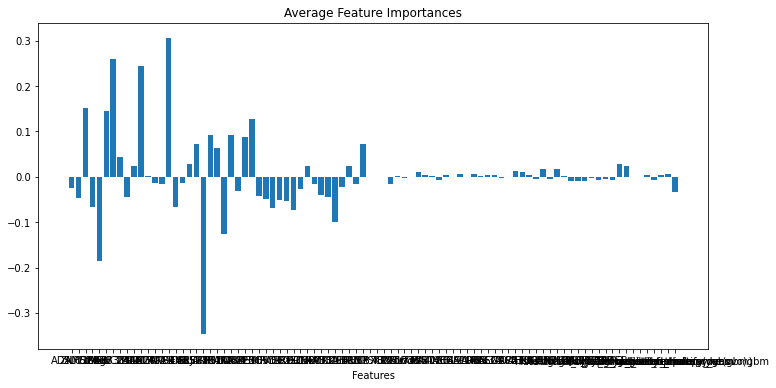

In [141]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

In [151]:
df_imp = pd.DataFrame({'feat': feature_names, 'imp': np.mean(attr, axis=0)})
df_imp['imp_abs'] = df_imp.imp.map(lambda x: abs(x))
df_imp = df_imp.sort_values('imp_abs', ascending=False).head(10)

<BarContainer object of 10 artists>

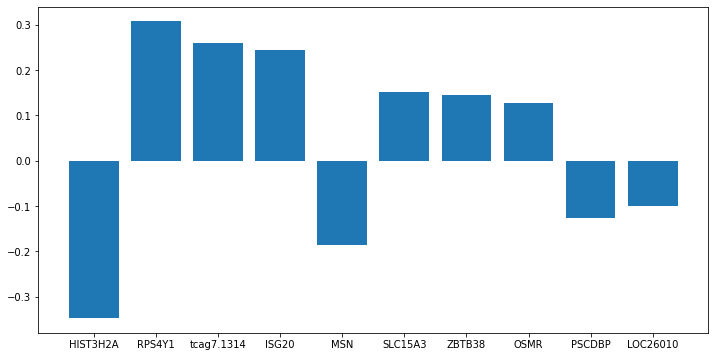

In [152]:
plt.figure(figsize=(12,6))
plt.bar(df_imp.feat, df_imp.imp, align='center')

In [156]:
from src.explain import explain

In [166]:
omic_group = ['RNA'] * len(r) + ['Met'] * len(m) + ['CNV'] * len(c) + ['Clin'] * len(df_clin.columns.to_list())

In [168]:
len(omic_group)

88

In [170]:
df_out = explain(model, dataset_test, feature_names, omic_group)

In [171]:
df_out

,Feature,Omic,Importance_value,Importance_value_abs
19,HIST3H2A,RNA,-3.450695e-01,3.450695e-01
14,RPS4Y1,RNA,3.046018e-01,3.046018e-01
6,tcag7.1314,RNA,2.579749e-01,2.579749e-01
10,ISG20,RNA,2.437747e-01,2.437747e-01
4,MSN,RNA,-1.862855e-01,1.862855e-01
...,...,...,...,...
55,EBF1,CNV,-3.179004e-04,3.179004e-04
43,TBX5,Met,1.314405e-04,1.314405e-04
44,RN7SKP216,Met,1.024261e-04,1.024261e-04
45,TBX3,Met,6.029371e-05,6.029371e-05


<AxesSubplot:xlabel='Importance_value', ylabel='Feature'>

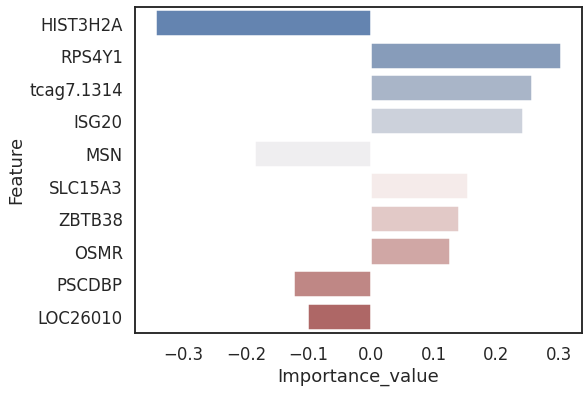

In [196]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme(style="white", context="talk")

fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.barplot(x='Importance_value', 
            y='Feature', 
            palette="vlag", 
            data=df_out.head(10),
            color=df_out["Feature"],
            ax=ax
           )
# ax.axhline(0, color="Omic", clip_on=False)
# ax2.set_ylabel("Diverging")


In [197]:
import os

os.path.join('/output', 'feature_importance.csv')

'/output/feature_importance.csv'

# GNN

In [50]:
def data_split(labels, test_size):
    """To split dataset into training dataset and testing dataset.
    Args:
        labels (numpy): The labels of samples.
        test_size (float, 0-1): The proportion of test data.
    
    Return:
        (list) index of training data, index of testing data
    """
    test_number = int(len(labels) * test_size)
    idx = list(range(len(labels)))
#     np.random.seed(102)
    np.random.shuffle(idx)
    return idx[test_number:], idx[:test_number]


In [51]:
def evaluate(logits, real_labels):
    """
    logits: sigmoid
    real_labels (numpy.array, dim=1)
    
    Return
        acc, auc, f1_score_, sens, spec
    """
    # acc
    pred = [1 if i > 0.5 else 0 for i in logits]
    acc = np.sum(np.array(pred) == np.array(real_labels)) / len(real_labels)
    acc = np.sum(np.array(pred) == np.array(real_labels.reshape(1,-1))[0]) / len(real_labels)

    # matrix
    TN, FP, FN, TP = confusion_matrix(y_true=real_labels, y_pred=pred).ravel()
    # auc
    fpr, tpr, thresholds = metrics.roc_curve(real_labels, logits, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    # F1 score
    f1_score_ = f1_score(y_true=real_labels, y_pred=pred)
    # sens / recall
    sens = TP/float(TP+FN)
    # spec
    spec = TN/float(TN+FP)
    return acc, auc, f1_score_, sens, spec

In [52]:
data = np.concatenate([
                       df_omics[0].iloc[:, rna].sort_index().values, 
                       df_omics[1].iloc[:, cnv].sort_index().values, 
                       df_omics[2].iloc[:, met].sort_index().values, 
                       df_clin.sort_index().values,
                      ],
                      1)

data = np.nan_to_num(data)
data = data.astype('float32')

labels = df_label.sort_index().label.values

# data = torch.tensor([data, labels], dtype=torch.float32)
dataset = []
for i in range(len(labels)):
    dataset.append([torch.tensor(data[i]), torch.tensor(labels[i])])
    
data.shape, labels.shape

((220, 88), (220,))

In [53]:
kg = KNNGraph(5)
sample_graph = kg(torch.tensor(data))

In [54]:
ll = torch.tensor(labels, dtype=torch.float32).reshape(-1,1)
x = torch.tensor(data)

sample_graph.ndata['label'] = torch.tensor(labels, dtype=torch.float32).reshape(-1,1)
sample_graph.ndata['x'] = torch.tensor(data)

sample_graph.ndata['x'].shape

torch.Size([220, 88])

In [55]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        
        self.conv1 = dglnn.GATConv(
            in_feats=in_feats, out_feats=256, num_heads=1)
        
        self.conv2 = dglnn.GATConv(
            in_feats=256, out_feats=128, num_heads=1)
        
        self.conv3 = dglnn.GATConv(
            in_feats=128, out_feats=64, num_heads=1)
        
        self.conv4 = dglnn.GATConv(
            in_feats=64, out_feats=1, num_heads=1)
        

    def forward(self, graph, h):
        with graph.local_scope():
            h = self.conv1(graph, h)
            h = h[:,0,:]
            h = torch.tanh(h)
            h = nn.Dropout(p=0.2)(h)
            
            h = self.conv2(graph, h)
            h = h[:,0,:]
            h = F.relu(h)
            h = nn.Dropout(p=0.4)(h)
            
            h = self.conv3(graph, h)
            h = h[:,0,:]
            h = F.relu(h)
            h = nn.Dropout(p=0.2)(h)
            
            
            h = self.conv4(graph, h)
            h = h[:,0,:]
            h = torch.sigmoid(h)
            
            return h

In [56]:
train_idx, test_idx = data_split(labels=sample_graph.ndata['label'], test_size=0.3)

indim= data.shape[1]

model = SAGE(indim, 256, 1)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

for epoch in range(300):
    model.train()
    # 使用所有节点(全图)进行前向传播计算
    logits = model(sample_graph, x)
    
    # 计算损失值
    loss = nn.BCELoss()(logits[train_idx], ll[train_idx] )
    
    # 进行反向传播计算
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    loss_epoch = loss.item()
    acc, auc, f1_score_, sens, spec = evaluate(logits=logits.detach().numpy()[train_idx], real_labels=sample_graph.ndata['label'][train_idx])
    print('Epoch {:2d} | Train_Loss {:.3f} | Train_ACC {:.3f} | Train_AUC {:.3f} | Train_F1_score {:.3f} | Train_Sens {:.3f} | Train_Spec {:.3f}'.format(
            epoch, loss_epoch, acc, auc, f1_score_, sens, spec)
            )

    acc, auc, f1_score_, sens, spec = evaluate(logits=logits.detach().numpy()[test_idx], real_labels=sample_graph.ndata['label'][test_idx])
    print('Epoch {:2d} | Test_Loss {:.3f} | Test_ACC {:.3f} | Test_AUC {:.3f} | Test_F1_score {:.3f} | Test_Sens {:.3f} | Test_Spec {:.3f}\n'.format(
            epoch, loss_epoch, acc, auc, f1_score_, sens, spec)
            )

Epoch  0 | Train_Loss 1.034 | Train_ACC 0.779 | Train_AUC 0.657 | Train_F1_score 0.876 | Train_Sens 1.000 | Train_Spec 0.000
Epoch  0 | Test_Loss 1.034 | Test_ACC 0.758 | Test_AUC 0.564 | Test_F1_score 0.862 | Test_Sens 1.000 | Test_Spec 0.000

Epoch  1 | Train_Loss 0.705 | Train_ACC 0.630 | Train_AUC 0.422 | Train_F1_score 0.767 | Train_Sens 0.783 | Train_Spec 0.088
Epoch  1 | Test_Loss 0.705 | Test_ACC 0.697 | Test_AUC 0.426 | Test_F1_score 0.811 | Test_Sens 0.860 | Test_Spec 0.188

Epoch  2 | Train_Loss 0.762 | Train_ACC 0.539 | Train_AUC 0.543 | Train_F1_score 0.647 | Train_Sens 0.542 | Train_Spec 0.529
Epoch  2 | Test_Loss 0.762 | Test_ACC 0.500 | Test_AUC 0.532 | Test_F1_score 0.602 | Test_Sens 0.500 | Test_Spec 0.500

Epoch  3 | Train_Loss 0.564 | Train_ACC 0.753 | Train_AUC 0.548 | Train_F1_score 0.854 | Train_Sens 0.925 | Train_Spec 0.147
Epoch  3 | Test_Loss 0.564 | Test_ACC 0.742 | Test_AUC 0.440 | Test_F1_score 0.847 | Test_Sens 0.940 | Test_Spec 0.125

Epoch  4 | Train_Los

Epoch 36 | Train_Loss 0.437 | Train_ACC 0.831 | Train_AUC 0.802 | Train_F1_score 0.894 | Train_Sens 0.917 | Train_Spec 0.529
Epoch 36 | Test_Loss 0.437 | Test_ACC 0.727 | Test_AUC 0.662 | Test_F1_score 0.830 | Test_Sens 0.880 | Test_Spec 0.250

Epoch 37 | Train_Loss 0.419 | Train_ACC 0.844 | Train_AUC 0.796 | Train_F1_score 0.907 | Train_Sens 0.975 | Train_Spec 0.382
Epoch 37 | Test_Loss 0.419 | Test_ACC 0.773 | Test_AUC 0.691 | Test_F1_score 0.865 | Test_Sens 0.960 | Test_Spec 0.188

Epoch 38 | Train_Loss 0.448 | Train_ACC 0.799 | Train_AUC 0.825 | Train_F1_score 0.883 | Train_Sens 0.975 | Train_Spec 0.176
Epoch 38 | Test_Loss 0.448 | Test_ACC 0.742 | Test_AUC 0.689 | Test_F1_score 0.850 | Test_Sens 0.960 | Test_Spec 0.062

Epoch 39 | Train_Loss 0.410 | Train_ACC 0.831 | Train_AUC 0.809 | Train_F1_score 0.893 | Train_Sens 0.908 | Train_Spec 0.559
Epoch 39 | Test_Loss 0.410 | Test_ACC 0.758 | Test_AUC 0.730 | Test_F1_score 0.846 | Test_Sens 0.880 | Test_Spec 0.375

Epoch 40 | Train_Los

Epoch 74 | Train_Loss 0.405 | Train_ACC 0.838 | Train_AUC 0.809 | Train_F1_score 0.898 | Train_Sens 0.917 | Train_Spec 0.559
Epoch 74 | Test_Loss 0.405 | Test_ACC 0.742 | Test_AUC 0.701 | Test_F1_score 0.838 | Test_Sens 0.880 | Test_Spec 0.312

Epoch 75 | Train_Loss 0.386 | Train_ACC 0.844 | Train_AUC 0.833 | Train_F1_score 0.907 | Train_Sens 0.975 | Train_Spec 0.382
Epoch 75 | Test_Loss 0.386 | Test_ACC 0.758 | Test_AUC 0.695 | Test_F1_score 0.855 | Test_Sens 0.940 | Test_Spec 0.188

Epoch 76 | Train_Loss 0.399 | Train_ACC 0.831 | Train_AUC 0.797 | Train_F1_score 0.898 | Train_Sens 0.950 | Train_Spec 0.412
Epoch 76 | Test_Loss 0.399 | Test_ACC 0.758 | Test_AUC 0.754 | Test_F1_score 0.855 | Test_Sens 0.940 | Test_Spec 0.188

Epoch 77 | Train_Loss 0.375 | Train_ACC 0.831 | Train_AUC 0.840 | Train_F1_score 0.895 | Train_Sens 0.925 | Train_Spec 0.500
Epoch 77 | Test_Loss 0.375 | Test_ACC 0.758 | Test_AUC 0.706 | Test_F1_score 0.852 | Test_Sens 0.920 | Test_Spec 0.250

Epoch 78 | Train_Los

Epoch 112 | Train_Loss 0.413 | Train_ACC 0.831 | Train_AUC 0.841 | Train_F1_score 0.902 | Train_Sens 1.000 | Train_Spec 0.235
Epoch 112 | Test_Loss 0.413 | Test_ACC 0.758 | Test_AUC 0.704 | Test_F1_score 0.860 | Test_Sens 0.980 | Test_Spec 0.062

Epoch 113 | Train_Loss 0.409 | Train_ACC 0.851 | Train_AUC 0.812 | Train_F1_score 0.912 | Train_Sens 0.992 | Train_Spec 0.353
Epoch 113 | Test_Loss 0.409 | Test_ACC 0.758 | Test_AUC 0.720 | Test_F1_score 0.857 | Test_Sens 0.960 | Test_Spec 0.125

Epoch 114 | Train_Loss 0.387 | Train_ACC 0.851 | Train_AUC 0.839 | Train_F1_score 0.911 | Train_Sens 0.983 | Train_Spec 0.382
Epoch 114 | Test_Loss 0.387 | Test_ACC 0.788 | Test_AUC 0.704 | Test_F1_score 0.873 | Test_Sens 0.960 | Test_Spec 0.250

Epoch 115 | Train_Loss 0.375 | Train_ACC 0.870 | Train_AUC 0.830 | Train_F1_score 0.922 | Train_Sens 0.983 | Train_Spec 0.471
Epoch 115 | Test_Loss 0.375 | Test_ACC 0.803 | Test_AUC 0.696 | Test_F1_score 0.883 | Test_Sens 0.980 | Test_Spec 0.250

Epoch 116 | 

Epoch 149 | Train_Loss 0.379 | Train_ACC 0.864 | Train_AUC 0.828 | Train_F1_score 0.917 | Train_Sens 0.967 | Train_Spec 0.500
Epoch 149 | Test_Loss 0.379 | Test_ACC 0.803 | Test_AUC 0.754 | Test_F1_score 0.881 | Test_Sens 0.960 | Test_Spec 0.312

Epoch 150 | Train_Loss 0.407 | Train_ACC 0.818 | Train_AUC 0.825 | Train_F1_score 0.887 | Train_Sens 0.917 | Train_Spec 0.471
Epoch 150 | Test_Loss 0.407 | Test_ACC 0.758 | Test_AUC 0.718 | Test_F1_score 0.852 | Test_Sens 0.920 | Test_Spec 0.250

Epoch 151 | Train_Loss 0.395 | Train_ACC 0.844 | Train_AUC 0.818 | Train_F1_score 0.905 | Train_Sens 0.950 | Train_Spec 0.471
Epoch 151 | Test_Loss 0.395 | Test_ACC 0.758 | Test_AUC 0.735 | Test_F1_score 0.852 | Test_Sens 0.920 | Test_Spec 0.250

Epoch 152 | Train_Loss 0.394 | Train_ACC 0.831 | Train_AUC 0.830 | Train_F1_score 0.893 | Train_Sens 0.908 | Train_Spec 0.559
Epoch 152 | Test_Loss 0.394 | Test_ACC 0.758 | Test_AUC 0.755 | Test_F1_score 0.849 | Test_Sens 0.900 | Test_Spec 0.312

Epoch 153 | 

Epoch 195 | Train_Loss 0.378 | Train_ACC 0.844 | Train_AUC 0.844 | Train_F1_score 0.908 | Train_Sens 0.992 | Train_Spec 0.324
Epoch 195 | Test_Loss 0.378 | Test_ACC 0.773 | Test_AUC 0.731 | Test_F1_score 0.865 | Test_Sens 0.960 | Test_Spec 0.188

Epoch 196 | Train_Loss 0.394 | Train_ACC 0.831 | Train_AUC 0.822 | Train_F1_score 0.900 | Train_Sens 0.975 | Train_Spec 0.324
Epoch 196 | Test_Loss 0.394 | Test_ACC 0.758 | Test_AUC 0.671 | Test_F1_score 0.857 | Test_Sens 0.960 | Test_Spec 0.125

Epoch 197 | Train_Loss 0.379 | Train_ACC 0.844 | Train_AUC 0.831 | Train_F1_score 0.905 | Train_Sens 0.950 | Train_Spec 0.471
Epoch 197 | Test_Loss 0.379 | Test_ACC 0.758 | Test_AUC 0.711 | Test_F1_score 0.855 | Test_Sens 0.940 | Test_Spec 0.188

Epoch 198 | Train_Loss 0.392 | Train_ACC 0.831 | Train_AUC 0.831 | Train_F1_score 0.893 | Train_Sens 0.908 | Train_Spec 0.559
Epoch 198 | Test_Loss 0.392 | Test_ACC 0.773 | Test_AUC 0.679 | Test_F1_score 0.857 | Test_Sens 0.900 | Test_Spec 0.375

Epoch 199 | 

Epoch 242 | Train_Loss 0.352 | Train_ACC 0.851 | Train_AUC 0.858 | Train_F1_score 0.908 | Train_Sens 0.942 | Train_Spec 0.529
Epoch 242 | Test_Loss 0.352 | Test_ACC 0.758 | Test_AUC 0.768 | Test_F1_score 0.849 | Test_Sens 0.900 | Test_Spec 0.312

Epoch 243 | Train_Loss 0.372 | Train_ACC 0.851 | Train_AUC 0.845 | Train_F1_score 0.911 | Train_Sens 0.975 | Train_Spec 0.412
Epoch 243 | Test_Loss 0.372 | Test_ACC 0.773 | Test_AUC 0.700 | Test_F1_score 0.862 | Test_Sens 0.940 | Test_Spec 0.250

Epoch 244 | Train_Loss 0.411 | Train_ACC 0.838 | Train_AUC 0.827 | Train_F1_score 0.903 | Train_Sens 0.975 | Train_Spec 0.353
Epoch 244 | Test_Loss 0.411 | Test_ACC 0.773 | Test_AUC 0.729 | Test_F1_score 0.865 | Test_Sens 0.960 | Test_Spec 0.188

Epoch 245 | Train_Loss 0.408 | Train_ACC 0.831 | Train_AUC 0.829 | Train_F1_score 0.902 | Train_Sens 1.000 | Train_Spec 0.235
Epoch 245 | Test_Loss 0.408 | Test_ACC 0.758 | Test_AUC 0.667 | Test_F1_score 0.860 | Test_Sens 0.980 | Test_Spec 0.062

Epoch 246 | 

Epoch 280 | Train_Loss 0.384 | Train_ACC 0.844 | Train_AUC 0.829 | Train_F1_score 0.902 | Train_Sens 0.925 | Train_Spec 0.559
Epoch 280 | Test_Loss 0.384 | Test_ACC 0.758 | Test_AUC 0.711 | Test_F1_score 0.849 | Test_Sens 0.900 | Test_Spec 0.312

Epoch 281 | Train_Loss 0.378 | Train_ACC 0.838 | Train_AUC 0.835 | Train_F1_score 0.903 | Train_Sens 0.975 | Train_Spec 0.353
Epoch 281 | Test_Loss 0.378 | Test_ACC 0.758 | Test_AUC 0.718 | Test_F1_score 0.857 | Test_Sens 0.960 | Test_Spec 0.125

Epoch 282 | Train_Loss 0.381 | Train_ACC 0.851 | Train_AUC 0.814 | Train_F1_score 0.913 | Train_Sens 1.000 | Train_Spec 0.324
Epoch 282 | Test_Loss 0.381 | Test_ACC 0.758 | Test_AUC 0.691 | Test_F1_score 0.857 | Test_Sens 0.960 | Test_Spec 0.125

Epoch 283 | Train_Loss 0.378 | Train_ACC 0.864 | Train_AUC 0.845 | Train_F1_score 0.919 | Train_Sens 0.992 | Train_Spec 0.412
Epoch 283 | Test_Loss 0.378 | Test_ACC 0.803 | Test_AUC 0.738 | Test_F1_score 0.883 | Test_Sens 0.980 | Test_Spec 0.250

Epoch 284 | 